In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# LSTM 車流量分析

## 套件載入

In [1]:
# Core Keras libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional

# For data conditioning
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

# Make results reproducible
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)

# Other essential libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import math

# Make our plot a bit formal
font = {
    'family': 'Arial',
    'weight': 'normal',
    'size': 10
}
plt.rc('font', **font)

## 資料載入

In [2]:
dataset = pd.read_csv('Z:/ETC/敬烜/ETC/training/01F0005S01F0017S.csv')

dataset
# print(dataset["平均車速"].describe())
# print(dataset["交通量"].describe())

,Date,Hours,Mean_Speed,Traffic
0,2019-1-1 0:00,0,85.032220,9249
1,2019-1-1 1:00,1,85.392148,9068
2,2019-1-1 2:00,2,85.181213,8719
3,2019-1-1 3:00,3,85.361773,8392
4,2019-1-1 4:00,4,85.097737,8615
...,...,...,...,...
8755,2019-12-31 19:00,19,78.524143,8864
8756,2019-12-31 20:00,20,78.605020,8565
8757,2019-12-31 21:00,21,78.451886,8376
8758,2019-12-31 22:00,22,79.343168,8914


## 設置 epoch、time stamp



In [103]:
n_timestamp = 24 * 2    # 根據資料可以看出每列資料式一小時，這裡設定參考 2 天
n_epochs = 30
filter_on = True       # 是否做資料處理
model_type = 1        # 1.Single cell LSTM 2.Stacked LSTM 3.Bidirectional LSTM
train_test_split = 0.8    # train 比例，以天做計算
dataset_column = 'Mean_Speed'   # 要預測的欄位
dataset_column1 = "時間"

## 資料處理

### 資料集做中值過濾 + 高斯過濾

In [104]:
def med_gau_filter(data, med_kernel=3, gau_kernel=1.2):
    data = medfilt(data, med_kernel)
    data = gaussian_filter1d(data, gau_kernel)
    return data
if filter_on:
    dataset[dataset_column] = med_gau_filter(dataset[dataset_column])

### 設置訓練、測試資料集

In [105]:
datalen = int(len(dataset) // 24 * .8) * 24
train_set = dataset[: datalen]
test_set = dataset[datalen: ]

training_set = tf.expand_dims(train_set[dataset_column], -1)
testing_set = tf.expand_dims(test_set[dataset_column], -1)

### 正規化(normalize) 資料，使資料值介於[0, 1]

In [106]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(testing_set)

### 產生 X, Y 資料集(reshape into X=t and Y=t+1)

In [107]:
def data_split(sequence, n_timestamp):
    dataX, dataY = [], []
    for i in range(len(sequence) - n_timestamp - 1):
        seq_x, seq_y = sequence[i: (i+n_timestamp), :], sequence[i + n_timestamp , :]
        dataX.append(seq_x)
        dataY.append(seq_y)
    return np.array(dataX), np.array(dataY)

X_train, y_train = data_split(training_set_scaled, n_timestamp)
X_test, y_test = data_split(testing_set_scaled, n_timestamp)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [108]:
(X_train.shape[1],1)

(48, 1)

## 建構 LSTM 模型

In [109]:
def build_lstm_model(X_train, model_type = 2):
    if model_type == 1:
        # Single cell LSTM
        model = Sequential()
        model.add(LSTM(units = 50, activation='relu', input_shape = (X_train.shape[1], 1)))
        model.add(Dense(units = 1))
    
    if model_type == 2:
        # Stacked LSTM
        model = Sequential()
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(50, activation='relu'))
        model.add(Dense(1))

    if model_type == 3:
        # Bidirectional LSTM
        model = Sequential()
        model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], 1)))
        model.add(Dense(1))

    return model

model = build_lstm_model(X_train, model_type)
model.compile(optimizer = 'adam', loss= 'mean_squared_error')

In [110]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


## 模型訓練

In [111]:
# history = model.fit(X_train, y_train, epochs = n_epochs, batch_size= 32)
print(input)
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size= 24,validation_data = (X_test,y_test))
loss = history.history['loss']
epochs = range(len(loss))

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000024BD5480808>>
Epoch 1/30
290/290 [==============================] - 2s 7ms/step - loss: 0.0154 - val_loss: 0.0129
Epoch 2/30
290/290 [==============================] - 2s 7ms/step - loss: 0.0018 - val_loss: 0.0112
Epoch 3/30
290/290 [==============================] - 2s 7ms/step - loss: 8.3835e-04 - val_loss: 0.0097
Epoch 4/30
290/290 [==============================] - 2s 7ms/step - loss: 6.7919e-04 - val_loss: 0.0094
Epoch 5/30
290/290 [==============================] - 2s 7ms/step - loss: 6.2383e-04 - val_loss: 0.0092
Epoch 6/30
290/290 [==============================] - 2s 7ms/step - loss: 5.9976e-04 - val_loss: 0.0089
Epoch 7/30
290/290 [==============================] - 2s 7ms/step - loss: 5.7329e-04 - val_loss: 0.0089
Epoch 8/30
290/290 [==============================] - 2s 7ms/step - loss: 5.5145e-04 - val_loss: 0.0084
Epoch 9/30
290/290 [==============================] - 2s 7ms/step - loss: 4.8

## 要用測試資料集來預測資料，所以將資料轉換回原始值

In [112]:
x_list=[]
y_list=[]

In [113]:
# train
x_train_predicted = model.predict(X_train)
x_train_predicted_descaled = sc.inverse_transform(x_train_predicted)
y_train_descaled = sc.inverse_transform(y_train)

# test
x_test_predicted = model.predict(X_test)
# print(x_test_predicted)
x_test_predicted_descaled = sc.inverse_transform(x_test_predicted)
# print(x_test_predicted_descaled)
y_test_descaled = sc.inverse_transform(y_test)
# print(x_test_predicted_descaled[963])
for n44 in x_test_predicted_descaled:
#     print(n44[0])
    x_list.append(n44[0])
for n4 in y_test_descaled:
    y_list.append(n4[0])
    
dict_={
    "Predict":x_list,
    "True":y_list
}
print("01F0880N --> 01F0750N 12月11號 04:00 預測交通量:", x_test_predicted_descaled[988][0])
print("01F0880N --> 01F0750N 12月11號 04:00 實際交通量:", y_test_descaled[988][0])
print("")
print('01F0880N --> 01F0750N 12月11號 04:00 預估平均車速 : 81.15467')
print('01F0880N --> 01F0750N 12月11號 04:00 實際平均車速 : 81.25361895087717')

01F0880N --> 01F0750N 12月11號 04:00 預測交通量: 78.88509
01F0880N --> 01F0750N 12月11號 04:00 實際交通量: 78.91281174323741

01F0880N --> 01F0750N 12月11號 04:00 預估平均車速 : 81.15467
01F0880N --> 01F0750N 12月11號 04:00 實際平均車速 : 81.25361895087717


In [114]:
result = pd.DataFrame(dict_)
result["error"] = (result["Predict"] - result["True"])/result["Predict"]
result["error"] = result["error"].apply(lambda x: format(x, '.2%'))
result

,Predict,True,error
0,79.428673,79.424621,0.01%
1,79.254799,79.274473,-0.02%
2,79.162750,79.133405,0.04%
3,79.052040,79.038059,0.02%
4,78.978058,78.995637,-0.02%
...,...,...,...
1698,78.633598,78.611825,0.03%
1699,78.539146,78.570396,-0.04%
1700,78.577080,78.628431,-0.07%
1701,78.718582,78.824724,-0.13%


## 計算 MSE、RMSE、R2
    R2: 結果接近1，模型越好；結果接近0，模型越差

In [115]:
mse = mean_squared_error(y_test_descaled, x_test_predicted_descaled)
rmse = np.sqrt(mean_squared_error(x_test_predicted_descaled, y_test_descaled))
r2 = r2_score(y_test_descaled, x_test_predicted_descaled)

print('mse = \t' + str(round(mse, 5)))
print('rmse = \t' + str(round(rmse, 5)))
print('r2 = \t' + str(round(r2, 5)))

mse = 	0.00186
rmse = 	0.04313
r2 = 	0.97532


## 訓練、測試、原始資料趨勢圖

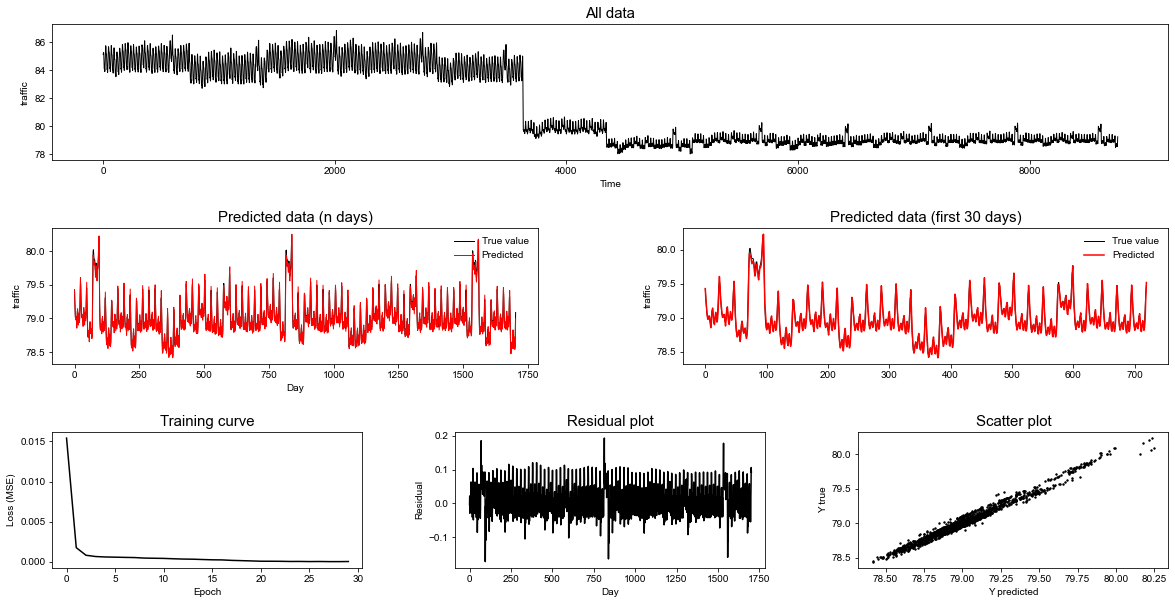

In [116]:
plt.figure(figsize=(20, 10))

# 觀察 原始資料，x = 原始資料、y = 時間
plt.subplot(3, 1, 1)
plt.plot(dataset[dataset_column], color='black', linewidth=1, label='True value')
plt.ylabel('traffic',fontsize=10)
plt.xlabel('Time',fontsize=10)
plt.title('All data',fontsize=15)

# 觀察 預測資料 (n 天)
plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color='black', linewidth=1, label='True value')
plt.plot(x_test_predicted_descaled, color='red', linewidth=1, label='Predicted')
plt.legend(frameon=False)
plt.ylabel('traffic',fontsize=10)
plt.xlabel('Day',fontsize=10)
plt.title('Predicted data (n days)',fontsize=15)

# 觀察 指定 預測天數的資料
plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[0: 24 * 30], color='black', linewidth=1, label='True value')
plt.plot(x_test_predicted_descaled[0: 24 * 30], color='red', label='Predicted')
plt.legend(frameon=False)
plt.ylabel('traffic',fontsize=10)
plt.title('Predicted data (first 30 days)',fontsize=15)

# 顯示訓練曲線
plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='black')
plt.ylabel('Loss (MSE)',fontsize=10)
plt.xlabel('Epoch',fontsize=10)
plt.title('Training curve',fontsize=15)

# 殘差圖- 觀測誤差用，用於檢驗模型的適當性
plt.subplot(3, 3, 8)
plt.plot(y_test_descaled - x_test_predicted_descaled, color='black')
plt.ylabel('Residual',fontsize=10)
plt.xlabel('Day',fontsize=10)
plt.title('Residual plot',fontsize=15)

# 散點圖- 展示數據的分布、聚合情況，並觀察趨勢
plt.subplot(3, 3, 9)
plt.scatter(x_test_predicted_descaled, y_test_descaled, s=2, color='black')
plt.ylabel('Y true',fontsize=10)
plt.xlabel('Y predicted',fontsize=10)
plt.title('Scatter plot',fontsize=15)

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

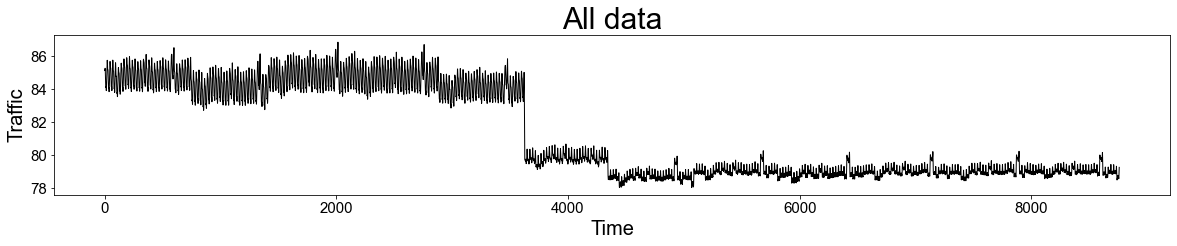

In [123]:
plt.figure(figsize=(20, 10))

# 觀察 原始資料，x = 原始資料、y = 時間
plt.subplot(3, 1, 1)
plt.plot(dataset[dataset_column], color='black', linewidth=1, label='True value')
plt.ylabel('Traffic',fontsize=20)
plt.xlabel('Time',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('All data',fontsize=30)
plt.savefig('1.png')

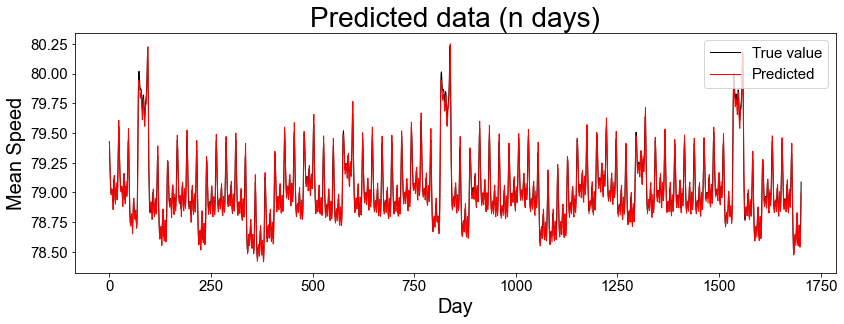

In [131]:
plt.figure(figsize=(30, 15))
plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color='black', linewidth=1, label='True value')
plt.plot(x_test_predicted_descaled, color='red', linewidth=1, label='Predicted')
plt.legend(frameon=False)
plt.ylabel('Mean Speed',fontsize=20)
plt.xlabel('Day',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.title('Predicted data (n days)',fontsize=28)
plt.savefig('1.png')

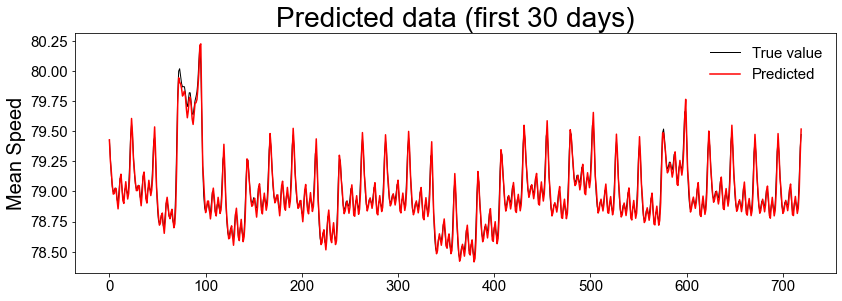

In [130]:
plt.figure(figsize=(30, 15))
plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[0: 24 * 30], color='black', linewidth=1, label='True value')
plt.plot(x_test_predicted_descaled[0: 24 * 30], color='red', label='Predicted')
plt.legend(frameon=False, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Mean Speed',fontsize=20)
plt.title('Predicted data (first 30 days)',fontsize=28)
plt.savefig('2.png')
# plt.xlabel(fontsize=20)


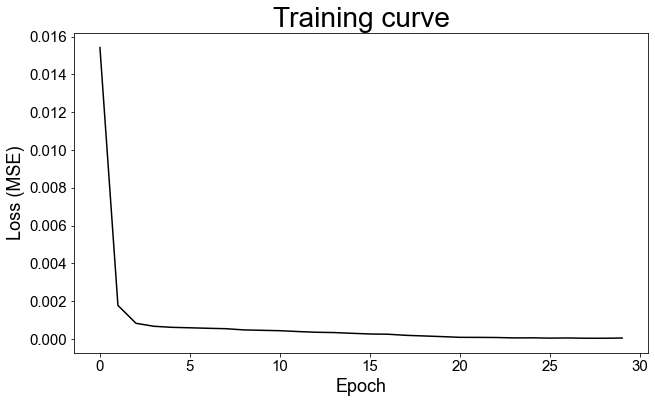

In [128]:
plt.figure(figsize=(35, 20))
plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='black')
plt.ylabel('Loss (MSE)',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Training curve',fontsize=28)
plt.savefig('3.png')

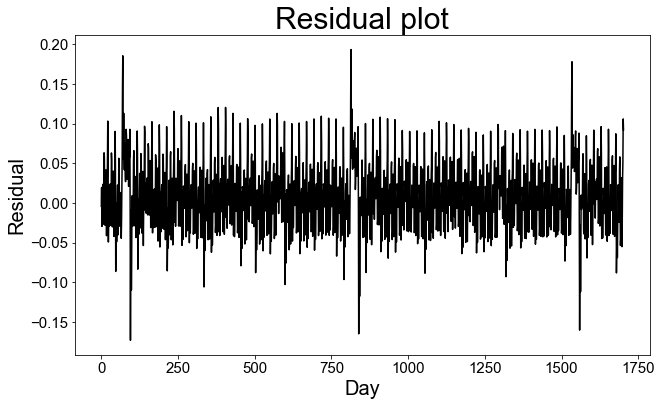

In [127]:
plt.figure(figsize=(35, 20))
plt.subplot(3, 3, 8)
plt.plot(y_test_descaled - x_test_predicted_descaled, color='black')
plt.ylabel('Residual',fontsize=20)
plt.xlabel('Day',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Residual plot',fontsize=30)
plt.savefig('4.png')

In [ ]:
plt.figure(figsize=(35, 20))
plt.subplot(3, 3, 9)
plt.scatter(x_test_predicted_descaled, y_test_descaled, s=2, color='black')
plt.ylabel('Y true',fontsize=20)
plt.xlabel('Y predicted',fontsize=20)
plt.title('Scatter plot',fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.savefig('5.png')

## 儲存模型

In [16]:
# import os
# model.save(os.path.join('C:/Users/PC/Desktop/ETC/731', 'last.h5'))